
# Assignment: Linear Regression, Logistic Regression, and K-Means (From Scratch)

**Instructions**
- You are NOT allowed to use `scikit-learn` for model implementation, scaling.
- You may use it for implementation of clustering
- You may use: `numpy`, `matplotlib`, and standard Python libraries only.
- Every step (scaling, loss, gradients, optimization) must be implemented manually.
- Clearly comment your code and explain your reasoning in Markdown cells.


## Question 1: Linear Regression from Scratch (with Standardization and Regularization)

You are given a dataset `(X, y)`.

### Tasks
1. Implement **StandardScaler manually**:
   - Compute mean and standard deviation for each feature.
   - Standardize the features.
2. Implement **Linear Regression using Gradient Descent**.
3. Add **L2 Regularization (Ridge Regression)**.
4. Plot:
   - Loss vs iterations
   - True vs predicted values

Do NOT use `sklearn`.


In [2]:

import numpy as np
import matplotlib.pyplot as plt


In [3]:

# Implement StandardScaler manually ,  first read about it, how it works and then implement it
class StandardScalerManual:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
        self.fitted_ = False

    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array")
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0, ddof=0)
        self.scale_ = np.where(self.scale_ < 1e-12, 1.0, self.scale_)
        self.fitted_ = True
        return self

    def transform(self, X):
        if not self.fitted_:
            raise RuntimeError("StandardScalerManual is not fitted yet")
        X = np.asarray(X, dtype=np.float64)
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        return self.fit(X).transform(X)



# This is a small sanity check
X_demo = np.array([[1.0, 2.0], [3.0, 0.0], [5.0, 4.0]])
sc_demo = StandardScalerManual()
Xz_demo = sc_demo.fit_transform(X_demo)

print("Scaler demo mean:", sc_demo.mean_)
print("Scaler demo std:", sc_demo.scale_)
print("Scaler demo transformed mean (approx):", Xz_demo.mean(axis=0))
print("Scaler demo transformed std (approx):", Xz_demo.std(axis=0))


Scaler demo mean: [3. 2.]
Scaler demo std: [1.63299316 1.63299316]
Scaler demo transformed mean (approx): [0. 0.]
Scaler demo transformed std (approx): [1. 1.]


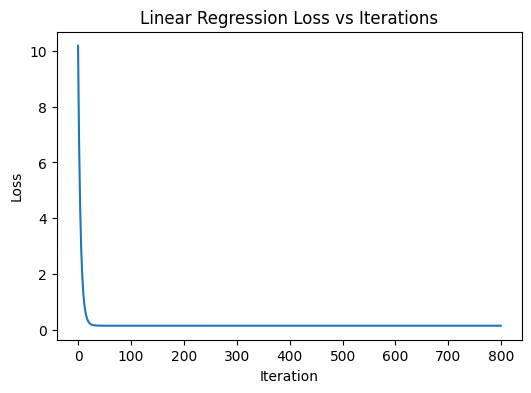

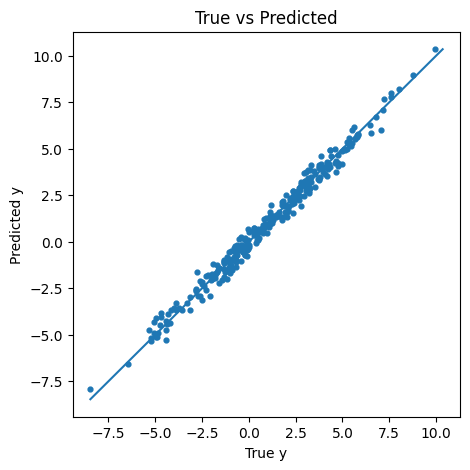

Final training MSE: 0.14446240160896348
Learned weights (bias first): [ 0.95673771  2.4846817  -1.63999903]


In [4]:

# Implement Linear Regression from scratch, here you have to also construct the regulization term coefficient of which will be
# denoted by l2_lambda
# try to implement L1 regularization or atlease read about it and where it is used
class LinearRegressionManual:
    def __init__(self, lr=0.01, epochs=1000, l2_lambda=0.0):
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.l2_lambda = float(l2_lambda)
        self.w = None
        self.loss_history = []

    def _add_bias(self, X):
        X = np.asarray(X, dtype=np.float64)
        ones = np.ones((X.shape[0], 1), dtype=np.float64)
        return np.concatenate([ones, X], axis=1)

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64).reshape(-1)

        if X.ndim != 2:
            raise ValueError("X must be a 2D array")
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples")

        Xb = self._add_bias(X)
        n, d = Xb.shape
        self.w = np.zeros(d, dtype=np.float64)
        self.loss_history = []

        for _ in range(self.epochs):
            yhat = Xb @ self.w
            err = yhat - y

            mse = (err @ err) / n
            reg = self.l2_lambda * (self.w[1:] @ self.w[1:])
            loss = mse + reg
            self.loss_history.append(float(loss))

            grad = (2.0 / n) * (Xb.T @ err)
            grad[1:] = grad[1:] + 2.0 * self.l2_lambda * self.w[1:]
            self.w = self.w - self.lr * grad

        return self

    def predict(self, X):
        if self.w is None:
            raise RuntimeError("Model not fitted yet")
        Xb = self._add_bias(X)
        return Xb @ self.w

# Using synthetic data to check implementation of the algorithm

np.random.seed(7)
n = 300
X = np.random.randn(n, 2)
true_w = np.array([2.5, -1.7])
y = X @ true_w + 0.8 + 0.4 * np.random.randn(n)

scaler = StandardScalerManual()
Xz = scaler.fit_transform(X)

model = LinearRegressionManual(lr=0.05, epochs=800, l2_lambda=1e-3)
model.fit(Xz, y)
y_pred = model.predict(Xz)

plt.figure(figsize=(6, 4))
plt.plot(model.loss_history)
plt.title("Linear Regression Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, s=12)
mn = min(y.min(), y_pred.min())
mx = max(y.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx])
plt.title("True vs Predicted")
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.show()

print("Final training MSE:", float(np.mean((y_pred - y) ** 2)))
print("Learned weights (bias first):", model.w)



## Question 2: Logistic Regression from Scratch (with Standardization and Regularization)

You are given a binary classification dataset.

### Tasks
1. Reuse your **manual StandardScaler**.
2. Implement **Logistic Regression using Gradient Descent**.
3. Use:
   - Sigmoid function
   - Binary Cross Entropy loss
4. Add **L2 Regularization**.
5. Report:
   - Training loss curve
   - Final accuracy

Do NOT use `sklearn`.


In [5]:

#Implement sigmoid function as told in the lectures
def sigmoid(z):
    z = np.asarray(z, dtype=np.float64)
    z = np.clip(z, -50.0, 50.0)
    return 1.0 / (1.0 + np.exp(-z))

print("sigmoid([-2,0,2]) =", sigmoid(np.array([-2.0, 0.0, 2.0])))



sigmoid([-2,0,2]) = [0.11920292 0.5        0.88079708]


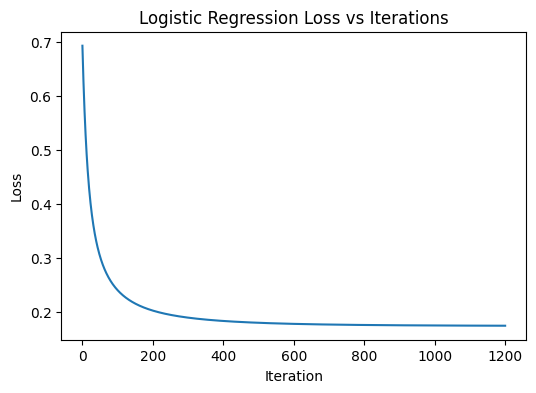

Final training accuracy: 0.936


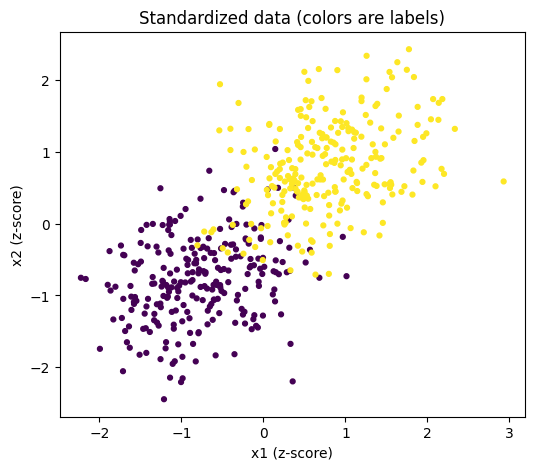

In [7]:
class LogisticRegressionManual:
    def __init__(self, lr=0.01, epochs=1000, l2_lambda=0.0):
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.l2_lambda = float(l2_lambda)
        self.w = None
        self.loss_history = []

    def _add_bias(self, A):
        A = np.asarray(A, dtype=np.float64)
        return np.c_[np.ones(A.shape[0]), A]

    def fit(self, A, b):
        A = np.asarray(A, dtype=np.float64)
        b = np.asarray(b, dtype=np.float64).ravel()

        if A.ndim != 2:
            raise ValueError("X must be a 2D array")
        if A.shape[0] != b.shape[0]:
            raise ValueError("X and y must have the same number of samples")
        if not np.all((b == 0) | (b == 1)):
            raise ValueError("y must be binary (0/1)")

        Ab = self._add_bias(A)
        m, k = Ab.shape
        self.w = np.zeros(k, dtype=np.float64)
        self.loss_history = []

        for _ in range(self.epochs):
            s = Ab @ self.w
            q = sigmoid(s)
            q = np.clip(q, 1e-12, 1.0 - 1e-12)

            loss_val = (
                -np.mean(b * np.log(q) + (1.0 - b) * np.log(1.0 - q))
                + self.l2_lambda * (self.w[1:] @ self.w[1:])
            )
            self.loss_history.append(float(loss_val))

            g = (Ab.T @ (q - b)) / m
            g[1:] += 2.0 * self.l2_lambda * self.w[1:]
            self.w -= self.lr * g

        return self

    def predict_proba(self, A):
        if self.w is None:
            raise RuntimeError("Model not fitted yet")
        return sigmoid(self._add_bias(A) @ self.w)

    def predict(self, A):
        return (self.predict_proba(A) >= 0.5).astype(np.int64)


np.random.seed(11)
n_a, n_b = 250, 250

mean_a = np.array([-1.2, -0.8])
mean_b = np.array([1.0, 1.3])
Sigma = np.array([[0.8, 0.2], [0.2, 0.7]])

A0 = np.random.multivariate_normal(mean_a, Sigma, size=n_a)
A1 = np.random.multivariate_normal(mean_b, Sigma, size=n_b)

A_all = np.vstack((A0, A1))
b_all = np.concatenate((
    np.zeros(n_a, dtype=np.int64),
    np.ones(n_b, dtype=np.int64)
))

scaler2 = StandardScalerManual()
A_std = scaler2.fit_transform(A_all)

clf = LogisticRegressionManual(lr=0.08, epochs=1200, l2_lambda=1e-3)
clf.fit(A_std, b_all)

plt.figure(figsize=(6, 4))
plt.plot(clf.loss_history)
plt.title("Logistic Regression Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

b_pred = clf.predict(A_std)
print("Final training accuracy:", float((b_pred == b_all).mean()))

plt.figure(figsize=(6, 5))
plt.scatter(A_std[:, 0], A_std[:, 1], c=b_all, s=12)
plt.title("Standardized data (colors are labels)")
plt.xlabel("x1 (z-score)")
plt.ylabel("x2 (z-score)")
plt.show()



## Question 3: K-Means Clustering from Scratch (Matrix Clustering)

You are given a **random matrix** `M` of shape `(n, m)`.

### Tasks
Implement K-Means clustering **from scratch** such that:

1. Input:
   - A random matrix `M`
   - Number of clusters `k`
2. Output:
   - `assignment_table`: a matrix of same shape as `M`, where each element stores the **cluster label**
   - `cookbook`: a dictionary (hashmap) where:
     - Key = cluster index
     - Value = list of **positions (i, j)** belonging to that cluster
   - `centroids`: array storing centroid values

You must cluster **individual elements**, not rows.


Centroids: [-1.89083774  2.07560557  4.2474571   0.21040777]
Cluster sizes: {0: 435, 1: 810, 2: 310, 3: 845}


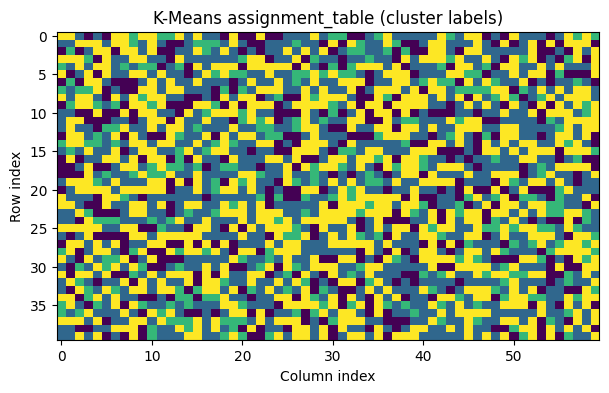

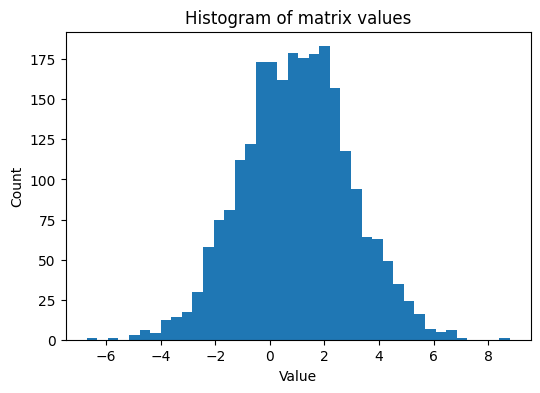

In [8]:

# Implement K-Means for matrix elements
#CAN USE SK-LEARN FOR THIS TASK AS THIS TASK WILL HELP US DIRECTLY IN OUR PROJECT !
def kmeans_matrix(A, clusters, max_iters=100):
    A = np.asarray(A, dtype=np.float64)
    if A.ndim != 2:
        raise ValueError("M must be a 2D matrix")
    if clusters <= 0:
        raise ValueError("k must be positive")

    flat = A.reshape(-1)
    total = flat.shape[0]
    gen = np.random.default_rng(42)

    if clusters > total:
        raise ValueError("k cannot be larger than number of elements")

    pick = gen.choice(total, size=clusters, replace=False)
    centers = flat[pick].copy()

    assign = np.zeros(total, dtype=np.int64)

    for _ in range(int(max_iters)):
        gap = np.abs(flat[:, None] - centers[None, :])
        new_assign = np.argmin(gap, axis=1)

        if np.array_equal(new_assign, assign):
            assign = new_assign
            break
        assign = new_assign

        for c in range(clusters):
            sel = assign == c
            if np.any(sel):
                centers[c] = flat[sel].mean()
            else:
                centers[c] = flat[gen.integers(0, total)]

    label_map = assign.reshape(A.shape)

    index_book = {cid: [] for cid in range(clusters)}
    rows, cols = A.shape
    for pos, cid in enumerate(assign):
        r = pos // cols
        c = pos % cols
        index_book[int(cid)].append((int(r), int(c)))

    return label_map, index_book, centers


np.random.seed(21)
A = np.random.randn(40, 60) * 2.0 + 1.0
clusters = 4

label_map, index_book, centers = kmeans_matrix(A, clusters=clusters, max_iters=80)

print("Centroids:", centers)
print("Cluster sizes:", {c: len(index_book[c]) for c in index_book})

plt.figure(figsize=(7, 4))
plt.imshow(label_map, aspect="auto")
plt.title("K-Means assignment_table (cluster labels)")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(A.reshape(-1), bins=40)
plt.title("Histogram of matrix values")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()



## Submission Guidelines
- Submit the completed `.ipynb` file.
- Clearly label all plots and outputs.
- Code readability and correctness matter.
- Partial credit will be given for logically correct implementations.

**Bonus**
- Compare convergence with and without standardization.
- Try different values of regularization strength.
